In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import solve_ivp
from tqdm import tqdm
from scipy.optimize import minimize
import scipy as sp
from scipy.integrate import solve_ivp
import numdifftools as nd

from numpy.linalg import eig

In [2]:
import os
if 'inference-from-testing' in os.getcwd():
    os.chdir("../..")
os.getcwd()

'/Users/user/Documents/GitHub/covid-19-in-households-public'

In [3]:
from copy import deepcopy
from numpy import arange, array, atleast_2d, log
from os import mkdir
from os.path import isdir, isfile
from pickle import load, dump
from pandas import read_csv
from scipy.integrate import solve_ivp
from model.preprocessing import ( estimate_beta_ext, estimate_growth_rate,
        SEIRInput, HouseholdPopulation, make_initial_condition_by_eigenvector)
from model.specs import SINGLE_AGE_SEIR_SPEC_FOR_FITTING, SINGLE_AGE_UK_SPEC
from model.common import SEIRRateEquations
from model.imports import FixedImportModel

In [26]:
DOUBLING_TIME = 3
growth_rate = log(2) / DOUBLING_TIME

comp_dist = read_csv(
    'inputs/england_hh_size_dist.csv',
    header=0).to_numpy().squeeze()
comp_dist = comp_dist[:3]
comp_dist[:2] *= 0
comp_dist = comp_dist/sum(comp_dist)
max_hh_size = len(comp_dist)
composition_list = np.atleast_2d(arange(1, max_hh_size+1)).T

#comp_dist = array([1.])
#composition_list = array([[1]])

if isdir('outputs') is False:
    mkdir('outputs')
if isdir('outputs/inference-from-testing') is False:
    mkdir('outputs/inference-from-testing')

SPEC = {**SINGLE_AGE_SEIR_SPEC_FOR_FITTING, **SINGLE_AGE_UK_SPEC}
model_input_to_fit = SEIRInput(SPEC, composition_list, comp_dist)
household_population_to_fit = HouseholdPopulation(
    composition_list, comp_dist, model_input_to_fit)
beta_ext = 0.
model_input = deepcopy(model_input_to_fit)
model_input.k_ext *= beta_ext

true_density_expo = model_input.density_expo


# With the parameters chosen, we calculate Q_int:
household_population = HouseholdPopulation(
    composition_list, comp_dist, model_input)

true_lam = 3.
pop_prev = 1e-2
rhs = SEIRRateEquations(model_input, household_population, FixedImportModel(4,1, np.array([true_lam * pop_prev])))

#r_est = estimate_growth_rate(household_population, rhs, [0.001, 5], 1e-9)


#print('Estimated growth rate is',r_est,'.')
#print('Estimated doubling time is',log(2) / r_est,'.')

H0 = np.zeros((household_population.total_size),)
all_sus = np.where(np.sum(rhs.states_exp_only + rhs.states_inf_only + rhs.states_rec_only, 1)<1e-1)[0]
one_inf = np.where((np.abs(np.sum(rhs.states_inf_only, 1) - 1)<1e-1) & (np.sum(rhs.states_exp_only + rhs.states_rec_only, 1)<1e-1))[0]
H0[all_sus] = 0.99 * comp_dist
H0[one_inf] = 0.01 * comp_dist
S0 = H0.T.dot(household_population.states[:, ::4])
E0 = H0.T.dot(household_population.states[:, 1::4])
I0 = H0.T.dot(household_population.states[:, 2::4])
R0 = H0.T.dot(household_population.states[:, 3::4])
start_state = (1/model_input.ave_hh_size) * array([S0.sum(),
                                                   E0.sum(),
                                                   I0.sum(),
                                                   R0.sum()])
tspan = (0.0, 365)
print(start_state)

Estimated beta_int= 0.01849526514675815 , estimated density= 0.5452971569851536
Estimated beta is 0.0
[0.99666667 0.         0.00333333 0.        ]


In [12]:
comp_dist

array([0., 0., 1.])

In [ ]:
composition_list

In [27]:
# Now set up evaluation time points and solve system:

# New time at which we evaluate the infection
trange = np.arange(0,7*12,7) # Evaluate for 12 weeks

# Solve:
solution = solve_ivp(rhs, tspan, H0, first_step=0.001, atol=1e-16, t_eval=trange)

time = solution.t
H = solution.y
S = H.T.dot(household_population.states[:, ::4])
E = H.T.dot(household_population.states[:, 1::4])
I = H.T.dot(household_population.states[:, 2::4])
R = H.T.dot(household_population.states[:, 3::4])

/var/folders/mn/cjzm0gtn7_z4bsq7d44zp_y00000gp/T/ipykernel_21353/852802733.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


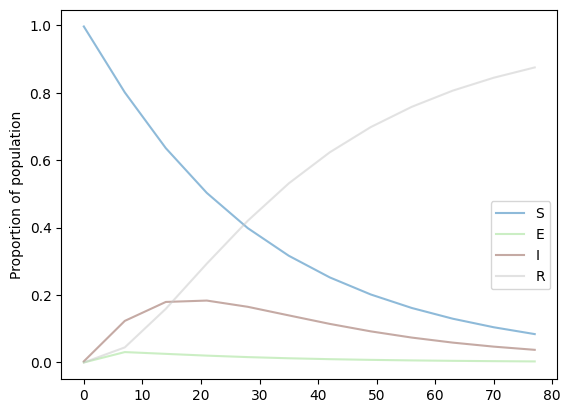

In [28]:
from matplotlib.pyplot import subplots
from matplotlib.cm import get_cmap

data_list = [S/model_input.ave_hh_by_class,
    E/model_input.ave_hh_by_class,
    I/model_input.ave_hh_by_class,
    R/model_input.ave_hh_by_class]

lgd=['S','E','I','R']

fig, (axis) = subplots(1,1, sharex=True)

cmap = get_cmap('tab20')
alpha = 0.5
for i in range(len(data_list)):
    axis.plot(
        time, data_list[i], label=lgd[i],
        color=cmap(i/len(data_list)), alpha=alpha)
axis.set_ylabel('Proportion of population')
axis.legend(ncol=1, bbox_to_anchor=(1,0.50))

In [29]:
H[H<0.0] = 0.0

Make test data for single-household trajectories and calculate LLH

In [30]:
from numpy.random import choice

H0 = make_initial_condition_by_eigenvector(growth_rate, model_input, household_population, rhs, 1e-1, 0.0,False,3)
test_times = np.arange(7,7*12,7)
def generate_single_hh_test_data(test_times):
    Ht = deepcopy(H0)
    test_data = np.zeros((len(test_times),))
    for i in range(len(test_times)-1):
        tspan = (test_times[i], test_times[i+1])
        solution = solve_ivp(rhs, tspan, Ht, first_step=0.001, atol=1e-16)
        time = solution.t
        H = solution.y
        state = choice(range(len(H[:, -1])), 1, p=H[:, -1]/sum(H[:, -1]))
        test_data[i] = rhs.states_inf_only[state]
        Ht *= 0
        Ht[state] = 1
    return(test_data)
sample_data = generate_single_hh_test_data(test_times)
print(sample_data)

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/var/folders/mn/cjzm0gtn7_z4bsq7d44zp_y00000gp/T/ipykernel_21353/3964832397.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_data[i] = rhs.states_inf_only[state]


In [31]:
# Log likelihood if we can only measure infecteds
# This is for test results from one household, you´ll need to adapt to multiple

def llh_from_test_data(test_data, test_times, rhs, H0):
    Ht = deepcopy(H0)
    llh = 0
    for i in range(len(test_times)-1):
        if i==0:
            start_time = 0
        else:
            start_time = test_times[i-1]
        tspan = (start_time, test_times[i])
        solution = solve_ivp(rhs, tspan, Ht, first_step=0.001, atol=1e-16)
        time = solution.t
        H = solution.y
        I = test_data[i]
        possible_states = np.where(np.abs(np.sum(rhs.states_inf_only,1)-I)<1e-1)[0]
        llh += np.log(np.sum(H[possible_states, -1]))
        Ht *= 0
        Ht[possible_states] = H[possible_states, -1]
    return(llh)

llh_from_test_data(sample_data, test_times, rhs, H0)

-27.51477845137201

Quick check to make sure the restricted trajectory locks on to the right thing:

In [32]:
# Log likelihood calculation but return probability trajectory

def llh_with_traj(test_data, test_times, rhs, H0):
    Ht = deepcopy(H0)
    H_all = np.atleast_2d(deepcopy(H0)).T
    t_all = np.array(0)
    llh = 0
    for i in range(len(test_times)-1):
        if i==0:
            start_time = 0
        else:
            start_time = test_times[i-1]
        tspan = (start_time, test_times[i])
        solution = solve_ivp(rhs, tspan, Ht, first_step=0.001, atol=1e-16)
        time = solution.t
        H = solution.y
        I = test_data[i]
        possible_states = np.where(np.abs(np.sum(rhs.states_inf_only,1)-I)<1e-1)[0]
        llh += np.log(np.sum(H[possible_states, -1]))
        Ht *= 0
        Ht[possible_states] = H[possible_states, -1]
        Ht = Ht/sum(Ht)
        H_all = np.hstack((H_all, H))
        t_all = np.hstack((t_all, time))
    return(llh, H_all, t_all)

llh, H_all, t_all = llh_with_traj(sample_data, test_times, rhs, H0)

/var/folders/mn/cjzm0gtn7_z4bsq7d44zp_y00000gp/T/ipykernel_21353/32998234.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


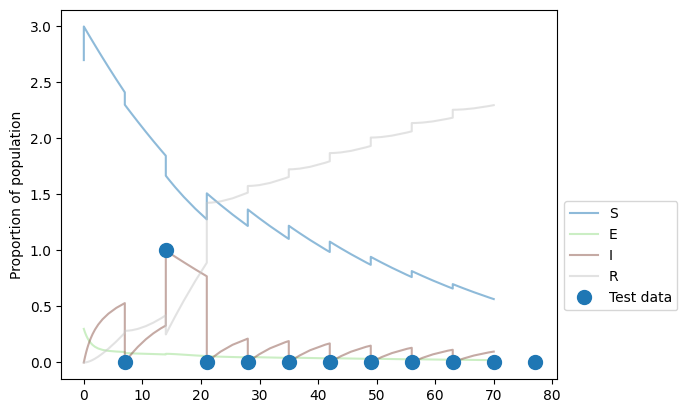

In [33]:
S = H_all.T.dot(household_population.states[:, ::4])
E = H_all.T.dot(household_population.states[:, 1::4])
I = H_all.T.dot(household_population.states[:, 2::4])
R = H_all.T.dot(household_population.states[:, 3::4])

data_list = [S/model_input.ave_hh_by_class,
    E/model_input.ave_hh_by_class,
    I/model_input.ave_hh_by_class,
    R/model_input.ave_hh_by_class]

lgd=['S','E','I','R', "Test data"]

fig, (axis) = subplots(1,1, sharex=True)

cmap = get_cmap('tab20')
alpha = 0.5
for i in range(len(data_list)):
    axis.plot(t_all,
        3*data_list[i], label=lgd[i],
        color=cmap(i/len(data_list)), alpha=alpha)
axis.plot(test_times, sample_data, marker=".", ls="", ms=20, label=lgd[-1])
axis.set_ylabel('Proportion of population')
axis.legend(ncol=1, bbox_to_anchor=(1,0.50))

In [65]:
# Now do multiple households

# Generate test data:
n_hh = 100
multi_hh_data = [generate_single_hh_test_data(test_times) for i in range(n_hh)]

# Option: Only include houses with at least one +ve
# multi_hh_data = [data for data in multi_hh_data if np.sum(data)>0]

/var/folders/mn/cjzm0gtn7_z4bsq7d44zp_y00000gp/T/ipykernel_21353/3964832397.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_data[i] = rhs.states_inf_only[state]


In [64]:
multi_hh_data

45

In [ ]:
# Try a single likelihood calculation

multi_hh_llh = sum(array([llh_from_test_data(sample_data, test_times, rhs, H0) for sample_data in multi_hh_data]))

At this point, we should be able to write a function taking parameters as input and calculating llh for those parameters.

In [36]:
def llh_from_pars(data, test_times, tau, lam):
    model_input = SEIRInput(SPEC, composition_list, comp_dist, print_ests=False)
    model_input.k_home = (tau / model_input.beta_int) * model_input.k_home
    model_input.k_ext = 0 * model_input.k_ext
    model_input.density_expo = true_density_expo
    # With the parameters chosen, we calculate Q_int:
    household_population = HouseholdPopulation(
        composition_list, comp_dist, model_input)
    # lam goes in as arg for rate equations
    rhs = SEIRRateEquations(model_input, household_population, FixedImportModel(4,1, np.array([lam * pop_prev])))
    H0 = make_initial_condition_by_eigenvector(growth_rate, model_input, household_population, rhs, 1e-2, 0.0,False,3)
    tspan = (0.0, 365)
    return(sum(array([llh_from_test_data(data, test_times, rhs, H0) for data in multi_hh_data])))

In [ ]:
llh_from_pars(multi_hh_data, test_times, 0.015, 2.75)

In [42]:
tau_vals = arange(0.015, 0.04, 0.005)
lam_vals = arange(2., 4.0, 0.25)
llh_vals = np.zeros((len(tau_vals), len(lam_vals)))
for i in range(len(tau_vals)):
    for j in range(len(lam_vals)):
        llh_vals[i,j] = llh_from_pars(multi_hh_data, test_times, tau_vals[i], lam_vals[j])
        print("tau=",tau_vals[i],", lam=",lam_vals[j], ", llh[tau, lam]=", llh_vals[i, j])

tau= 0.015 , lam= 2.0 , llh[tau, lam]= -7755.66389819731
tau= 0.015 , lam= 2.25 , llh[tau, lam]= -7693.921478606358
tau= 0.015 , lam= 2.5 , llh[tau, lam]= -7650.698611932418
tau= 0.015 , lam= 2.75 , llh[tau, lam]= -7621.613450164751
tau= 0.015 , lam= 3.0 , llh[tau, lam]= -7603.52234027351
tau= 0.015 , lam= 3.25 , llh[tau, lam]= -7594.073010028328
tau= 0.015 , lam= 3.5 , llh[tau, lam]= -7591.567356267735
tau= 0.015 , lam= 3.75 , llh[tau, lam]= -7594.685941570518
tau= 0.017 , lam= 2.0 , llh[tau, lam]= -7749.844946377001
tau= 0.017 , lam= 2.25 , llh[tau, lam]= -7689.364929482253
tau= 0.017 , lam= 2.5 , llh[tau, lam]= -7647.154176478938
tau= 0.017 , lam= 2.75 , llh[tau, lam]= -7618.913116374754
tau= 0.017 , lam= 3.0 , llh[tau, lam]= -7601.543237344209
tau= 0.017 , lam= 3.25 , llh[tau, lam]= -7592.7073443413265
tau= 0.017 , lam= 3.5 , llh[tau, lam]= -7590.740513283077
tau= 0.017 , lam= 3.75 , llh[tau, lam]= -7594.330089354427
tau= 0.019000000000000003 , lam= 2.0 , llh[tau, lam]= -7744.66054

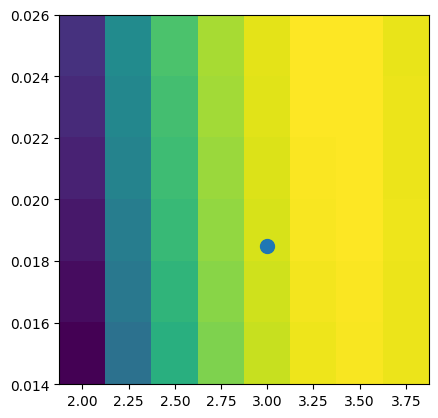

In [46]:
fig, ax = subplots(1, 1)
lam_inc = lam_vals[1] - lam_vals[0]
lam_max = lam_vals[-1] + (lam_vals[1]-lam_vals[0])
lam_range = lam_max - lam_vals[0]
tau_inc = tau_vals[1] - tau_vals[0]
tau_max = tau_vals[-1] + (tau_vals[1]-tau_vals[0])
tau_range = tau_max - tau_vals[0]
ax.imshow(llh_vals,
            origin='lower',
            extent=(lam_vals[0]-0.5*lam_inc,lam_max-0.5*lam_inc,tau_vals[0]-0.5*tau_inc,tau_max-0.5*tau_inc),
         aspect=lam_range/tau_range)
ax.plot([true_lam],
        [model_input.beta_int],
        marker=".",
        ms=20)

tau= 0.015
tau= 0.02
tau= 0.025
tau= 0.030000000000000002
tau= 0.035
lam= 2.0
lam= 2.25
lam= 2.5
lam= 2.75
lam= 3.0
lam= 3.25
lam= 3.5
lam= 3.75


Text(0, 0.5, 'log likelihood')

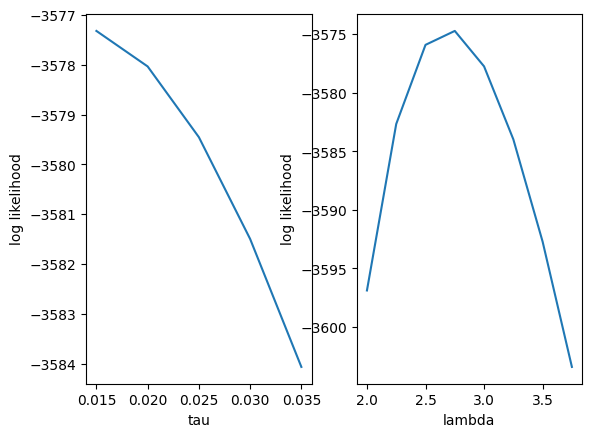

In [69]:
llh_fixed_lam = np.zeros((len(tau_vals),))
for i in range(len(tau_vals)):
    print("tau=",tau_vals[i])
    llh_fixed_lam[i] = llh_from_pars(multi_hh_data, test_times, tau_vals[i], true_lam)

llh_fixed_tau = np.zeros((len(lam_vals),))
for i in range(len(lam_vals)):
    print("lam=",lam_vals[i])
    llh_fixed_tau[i] = llh_from_pars(multi_hh_data, test_times, model_input.beta_int, lam_vals[i])

fig, (ax1, ax2) = subplots(1, 2)
ax1.plot(tau_vals, llh_fixed_lam)
ax1.set_xlabel("tau")
ax1.set_ylabel("log likelihood")
ax2.plot(lam_vals, llh_fixed_tau)
ax2.set_xlabel("lambda")
ax2.set_ylabel("log likelihood")

Try using a root finder approach:

In [67]:
def get_tau_lam_mles(data,test_times,tau_0,lam_0):
    def f(params):
        tau = params[0]
        lam = params[1]
        return -llh_from_pars(data, test_times, tau, lam)

    mle=sp.optimize.minimize(f,[tau_0,lam_0],bounds=((0.005, 0.05),(2., 5.)))
    return mle.x[0],mle.x[1]

In [68]:
tau_hat, lam_hat = get_tau_lam_mles(multi_hh_data, test_times, 0.02, 2.5)
print("MLE of tau=", tau_hat)
print("MLE of lam=", lam_hat)

MLE of tau= 0.017796844015391437
MLE of lam= 2.6913714253046677
